In [21]:
import numpy as np
import pandas as pd
import os
import sys
import pickle
import time
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from ORAN_dataset import *

File config

In [22]:
# Notebook config
labels = {0: 'eMBB', 1: 'mMTC', 2: 'URLLc', 3: 'CTRL'}
font = {'size'   : 22}
matplotlib.rc('font', **font)
np.random.seed(42)

ds_pkl_path = "../logs/"
# Data file config
# Trial 7
ds_file = "SingleUE/dataset__emuc__Trial7__slice16_singleUE_raw_debug_CNTRL_trial7_raw__globalnorm.pkl"
norm_param_path = "../logs/global__cols_maxmin__debug_CNTRL_trial7_raw_slice16.pkl"
# Trial 1-6
#ds_file = "SingleUE/prev_experiments/dataset__emuc__Trial1_Trial2_Trial3_Trial4_Trial5_Trial6__slice16__globalnorm.pkl"
#norm_param_path = "../logs/SingleUE/prev_experiments/global__cols_maxmin__prevexp_globalnorm_slice16.pkl"
ds_path = "../"

T = int(norm_param_path.split('slice')[-1].split('.')[0])

In [23]:
args = {
    "ds_file": [ds_file],
    "isNorm": True,
    "ds_path": ds_pkl_path,
    "norm_param_path": norm_param_path,
    "relabel_train": False
}
    
print("--- Loading Train dataset without relabeling...")
# Not relabeled
ds_train_nr = ORANTracesDataset(args["ds_file"], key='train', normalize=args["isNorm"], sanitize=False, path=args["ds_path"], norm_par_path=args["norm_param_path"], relabel_CTRL=args["relabel_train"])
ds_info = ds_train_nr.info()
print(ds_info)
print("--- Loading Train dataset relabeling...")
# Relabeled
args['relabel_train'] = True
ds_train_rel = ORANTracesDataset(args["ds_file"], key='train', normalize=args["isNorm"], sanitize=False, path=args["ds_path"], norm_par_path=args["norm_param_path"], relabel_CTRL=args["relabel_train"])
ds_info = ds_train_rel.info()
print(ds_info)

--- Loading Train dataset without relabeling...
{'numfeats': 17, 'slice_len': 16, 'numsamps': 79715, 'nclasses': 4, 'samples_per_class': array([29073, 27829, 22376,   437])}
--- Loading Train dataset relabeling...
Initial # samps. per label (before relabeling)
	 Labels: [0 1 2 3] Count: [29073 27829 22376   437]
	Labels that contain norm < threshold [0 1 2 3] 
	Num of samples per label with norm < threshold: [10454 14624  8010   391]
Tot. samples relabeled (for every class): 33088
{'numfeats': 17, 'slice_len': 16, 'numsamps': 79715, 'nclasses': 4, 'samples_per_class': array([18619, 13205, 14366, 33525])}


In [24]:
# Check if X of datasets are the same 
df_rn = []
df_r = []
for i in range(len(ds_train_nr)):
    df_rn.append(ds_train_nr[i][0].flatten().numpy())
    df_r.append(ds_train_rel[i][0].flatten().numpy())
    
result = True
# Check if the lists are identical
for k in range(len(df_r)):
    if not (df_rn[k] == df_r[k]).all():
        result = False
        
# Print the result
print("The lists are identical:", result)

The lists are identical: True


In [ ]:
N = 10000000
samples_per_class = [0, 0, 0, 0]
df_subset = []
df_classes_nr = []
df_classes_r = []

for i in range(len(ds_train_rel)):
    # If we have enough samples of that class do not add
    label_rel = ds_train_rel[i][1].item()
    label_nr = ds_train_nr[i][1].item()
    if samples_per_class[label_rel] < N:
        df_subset.append(ds_train_rel[i][0].flatten().numpy())
        df_classes_r.append(label_rel)
        samples_per_class[ds_train_rel[i][1].item()] += 1
        df_classes_nr.append(label_nr)
        

df_subset = np.array(df_subset)

In [27]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, learning_rate='auto',init='random', perplexity=50, n_iter=1000)
tsne_results = tsne.fit_transform(df_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 79715 samples in 0.017s...
[t-SNE] Computed neighbors for 79715 samples in 131.681s...
[t-SNE] Computed conditional probabilities for sample 1000 / 79715
[t-SNE] Computed conditional probabilities for sample 2000 / 79715
[t-SNE] Computed conditional probabilities for sample 3000 / 79715
[t-SNE] Computed conditional probabilities for sample 4000 / 79715
[t-SNE] Computed conditional probabilities for sample 5000 / 79715
[t-SNE] Computed conditional probabilities for sample 6000 / 79715
[t-SNE] Computed conditional probabilities for sample 7000 / 79715
[t-SNE] Computed conditional probabilities for sample 8000 / 79715
[t-SNE] Computed conditional probabilities for sample 9000 / 79715
[t-SNE] Computed conditional probabilities for sample 10000 / 79715
[t-SNE] Computed conditional probabilities for sample 11000 / 79715
[t-SNE] Computed conditional probabilities for sample 12000 / 79715
[t-SNE] Computed conditional probabilities for 

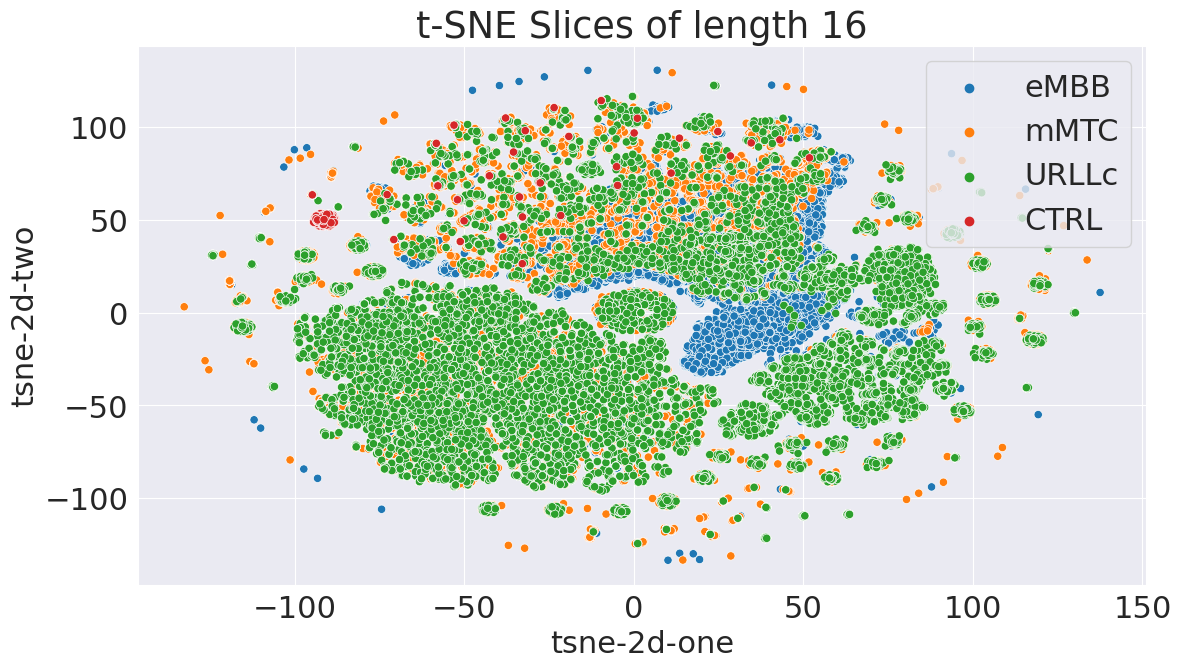

In [28]:
fig = plt.figure(figsize=(13,7))
df_plot = pd.DataFrame.from_dict({'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1]})
df_plot['class'] = df_classes_nr
df_plot['Class'] = df_plot['class'].apply(lambda x: labels[x])
df_plot.sort_values(by=['class'], inplace=True)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Class',
    hue_order = ['eMBB', 'mMTC', 'URLLc', 'CTRL'],
    palette=sns.color_palette("tab10", 4),
    data=df_plot,
    legend="full",
    alpha=1
).set(title=f't-SNE Slices of length {T}')
plt.legend(loc='upper right')
plt.savefig(f"../logs/SingleUE/prev_experiments/Before relabeling Slice {T}.png", transparent=True)

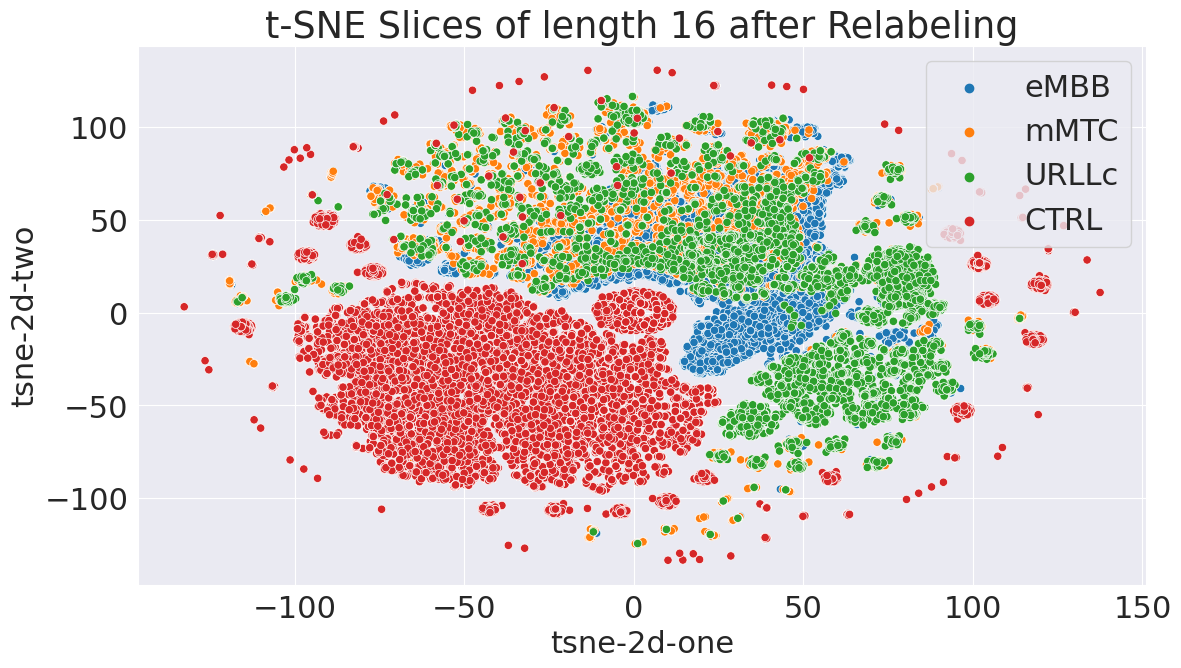

In [29]:
plt.figure(figsize=(13,7))
df_plot = pd.DataFrame.from_dict({'tsne-2d-one': tsne_results[:,0], 'tsne-2d-two': tsne_results[:,1]})
df_plot['class'] = df_classes_r
df_plot['Class'] = df_plot['class'].apply(lambda x: labels[x])
df_plot.sort_values(by=['class'], inplace=True)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='Class',
    hue_order = ['eMBB', 'mMTC', 'URLLc', 'CTRL'],
    palette=sns.color_palette("tab10", 4),
    data=df_plot,
    legend="full",
    alpha=1
).set(title=f't-SNE Slices of length {T} after Relabeling')
plt.legend(loc='upper right')
plt.savefig(f"../logs/SingleUE/prev_experiments/Relabeled Slice {T}.png", transparent=True)

In [30]:
df_subset.shape

(79715, 272)

In [50]:
df_subset_og_shape = df_subset.reshape((df_subset.shape[0],16,17))

Non-CTRL sample # 16927


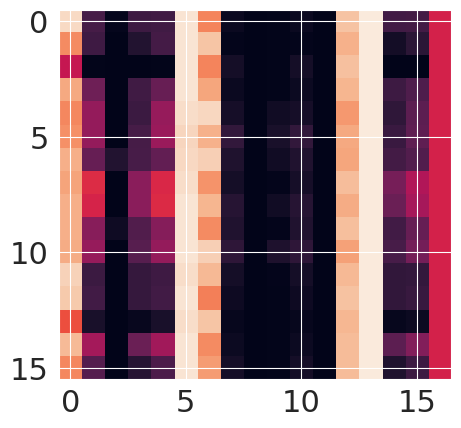

In [78]:
ix = np.random.choice(np.where(np.array(df_classes_r) != 3)[0])
print("Non-CTRL sample #", ix)
matplotlib.pyplot.imshow(df_subset_og_shape[ix])

In [76]:
ctrl_after_relabel_ixs = np.where(np.array(df_classes_r) == 3)[0]

ORIGINAL LABEL: 0 COORDINATES [ -23.8617 -27.45164 ]


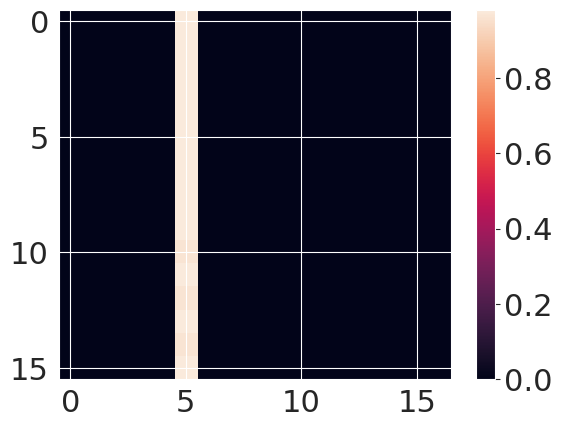

ORIGINAL LABEL: 0 COORDINATES [ -80.89562 -54.833866 ]


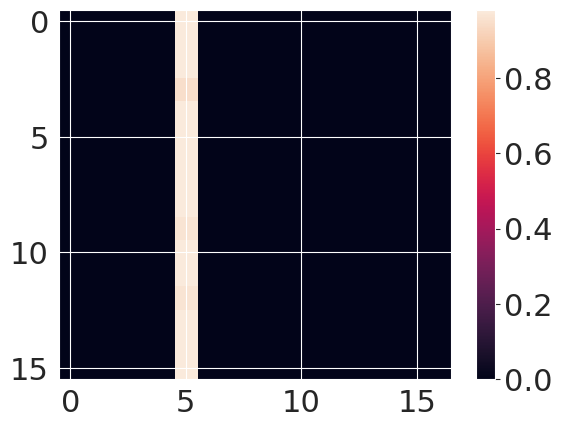

ORIGINAL LABEL: 1 COORDINATES [ -88.076805 -18.504534 ]


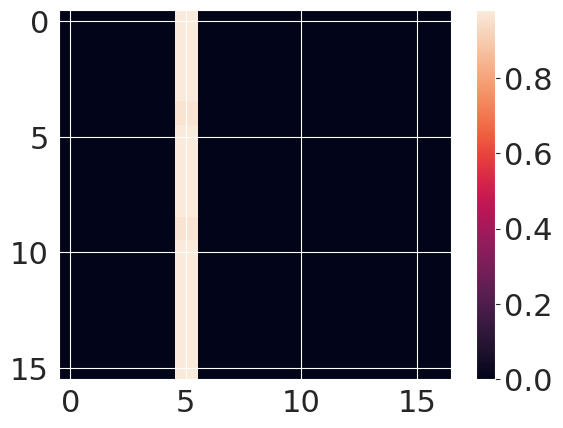

ORIGINAL LABEL: 2 COORDINATES [ -33.18657 -25.863064 ]


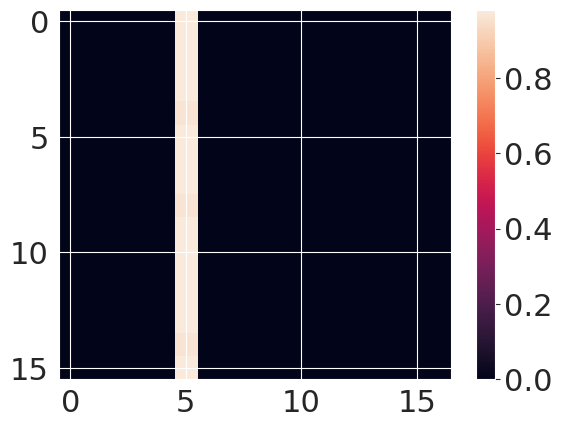

ORIGINAL LABEL: 0 COORDINATES [ -80.076996 -48.752712 ]


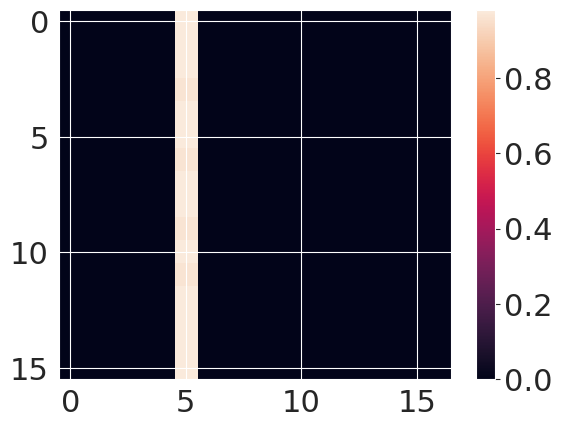

ORIGINAL LABEL: 2 COORDINATES [ -28.911205 -74.39169 ]


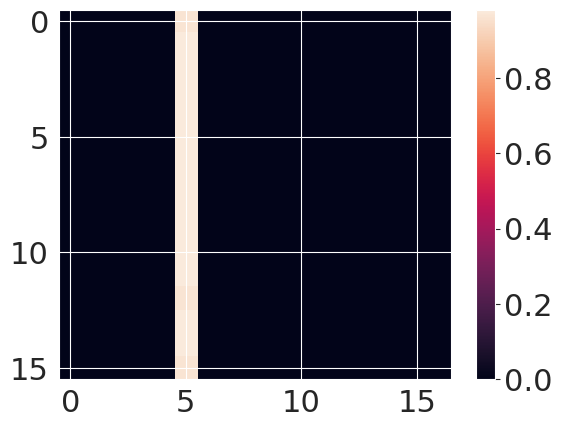

ORIGINAL LABEL: 1 COORDINATES [ -36.60978 -22.873888 ]


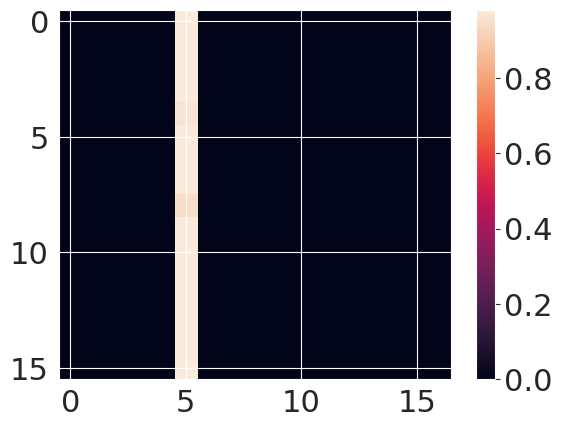

ORIGINAL LABEL: 0 COORDINATES [ -50.723473 -65.04092 ]


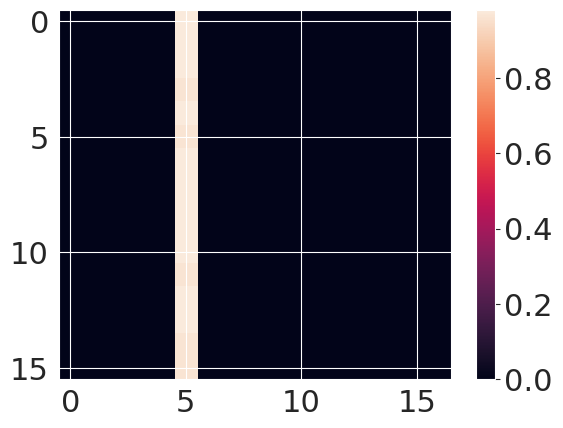

ORIGINAL LABEL: 1 COORDINATES [ -65.11501 -52.64204 ]


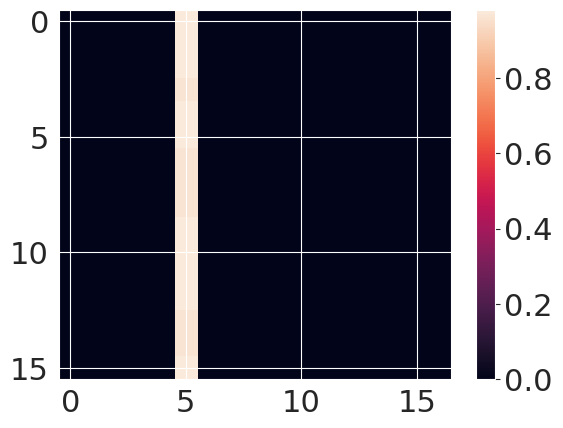

ORIGINAL LABEL: 2 COORDINATES [ -82.433464 -14.552004 ]


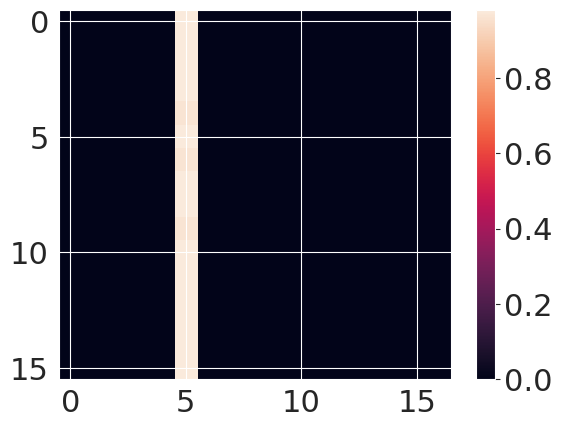

ORIGINAL LABEL: 1 COORDINATES [ -81.71601 -21.11651 ]


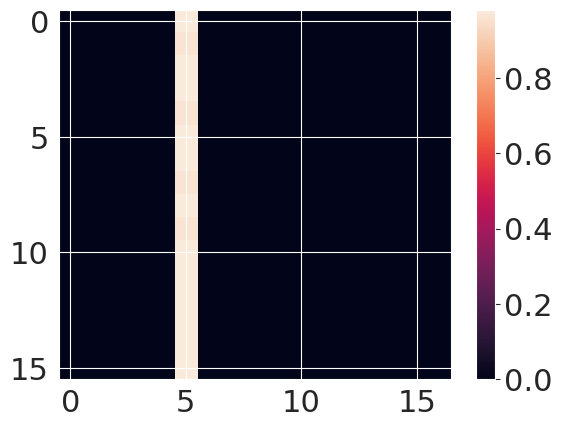

ORIGINAL LABEL: 0 COORDINATES [ -19.875233 -73.223755 ]


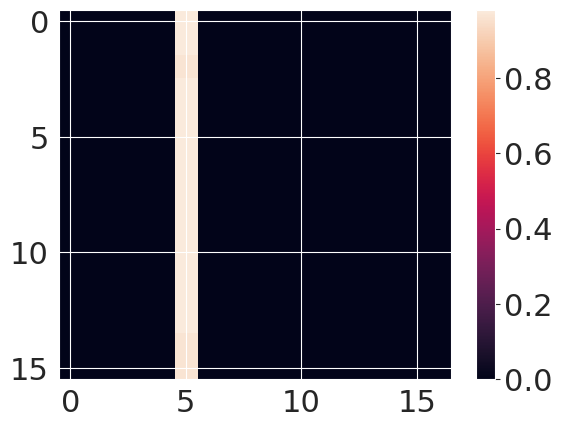

ORIGINAL LABEL: 0 COORDINATES [ -32.63317 -55.540775 ]


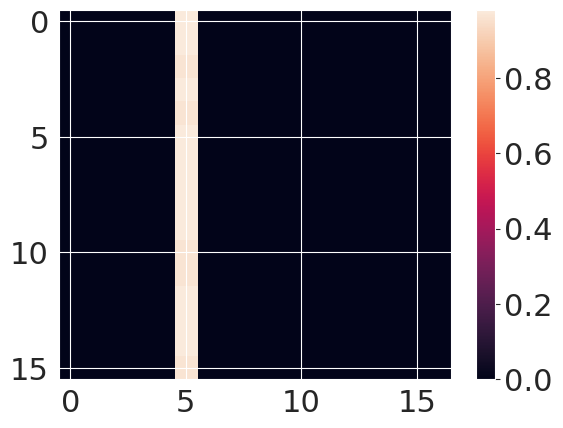

ORIGINAL LABEL: 2 COORDINATES [ -29.226841 -93.60451 ]


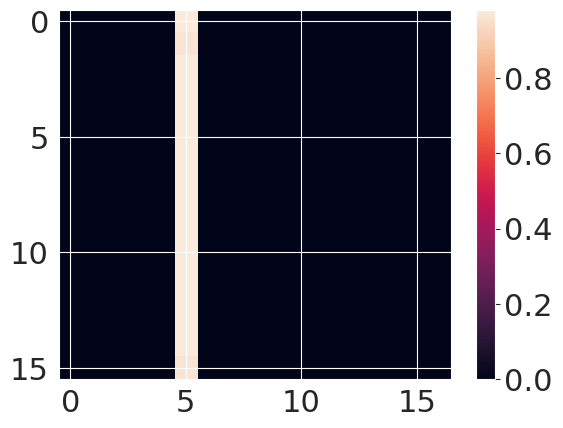

ORIGINAL LABEL: 2 COORDINATES [ -78.16595 -6.658224 ]


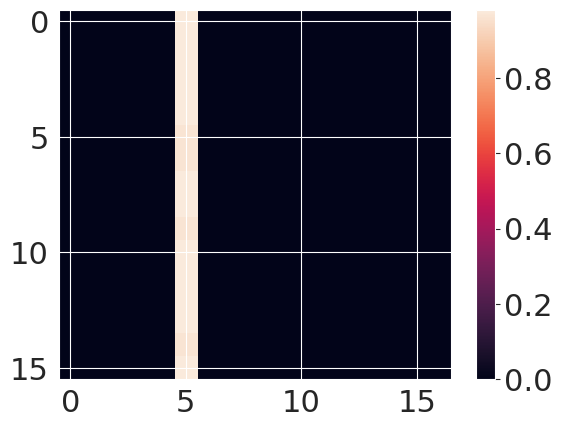

In [81]:
for c_ix in np.random.choice(ctrl_after_relabel_ixs, size=[30,]):
    if (0 > tsne_results[c_ix,0] > -100) and (0 > tsne_results[c_ix,1] > -100):
        print("ORIGINAL LABEL:", df_classes_nr[c_ix], "COORDINATES [", tsne_results[c_ix,0], tsne_results[c_ix,1], "]")
        matplotlib.pyplot.imshow(df_subset_og_shape[c_ix])
        matplotlib.pyplot.colorbar()
        matplotlib.pyplot.show()
        

In [82]:
ctrl_before_relabel_ixs = np.where(np.array(df_classes_nr) == 3)[0]

ORIGINAL LABEL: 3 COORDINATES [ -27.884531 69.824394 ]


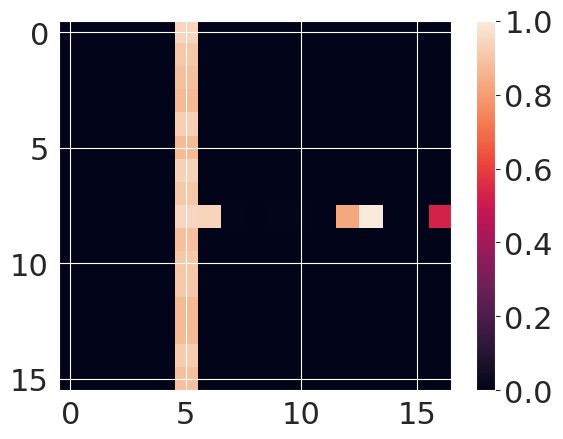

ORIGINAL LABEL: 3 COORDINATES [ -33.592186 62.02329 ]


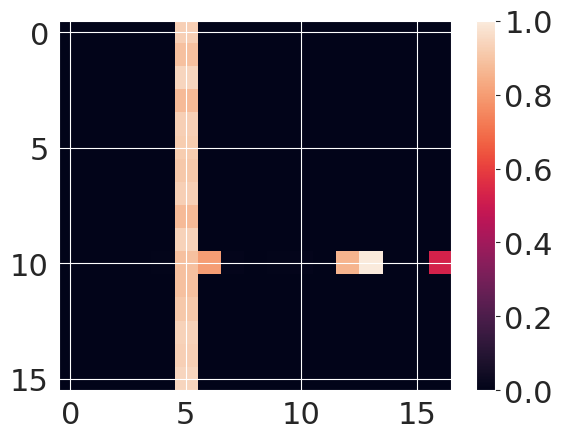

ORIGINAL LABEL: 3 COORDINATES [ -51.99801 60.71824 ]


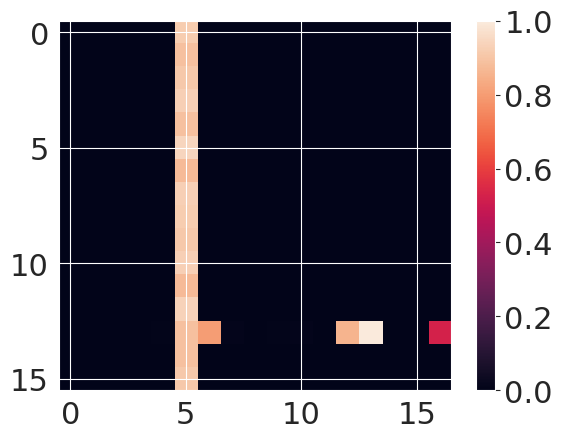

ORIGINAL LABEL: 3 COORDINATES [ 24.777681 97.433014 ]


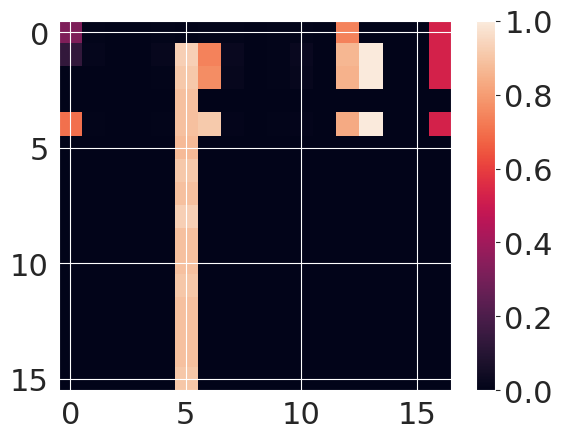

ORIGINAL LABEL: 3 COORDINATES [ -42.79308 73.461494 ]


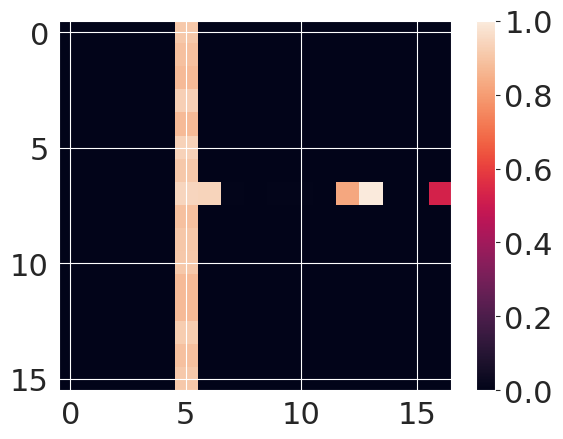

ORIGINAL LABEL: 3 COORDINATES [ -72.75256 63.511734 ]


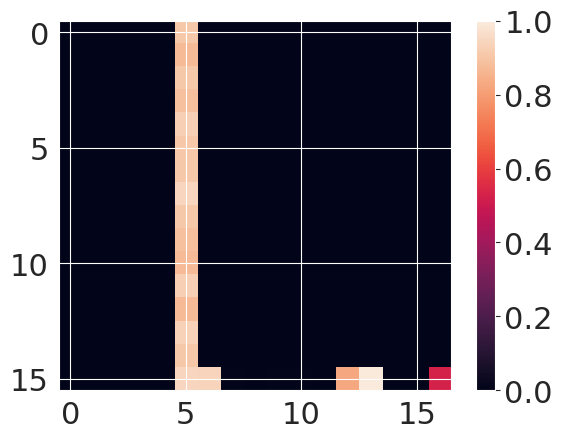

ORIGINAL LABEL: 3 COORDINATES [ -58.246418 91.090385 ]


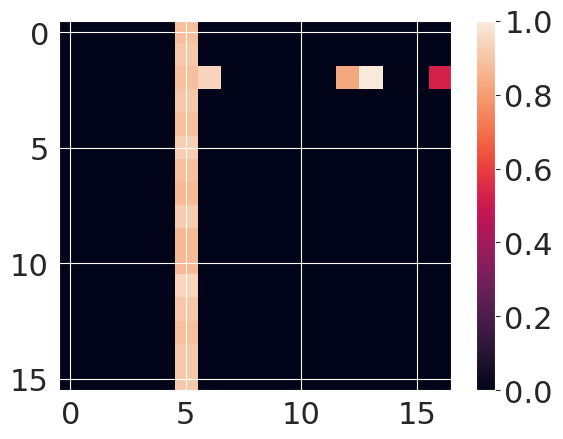

ORIGINAL LABEL: 3 COORDINATES [ -4.766829 68.45722 ]


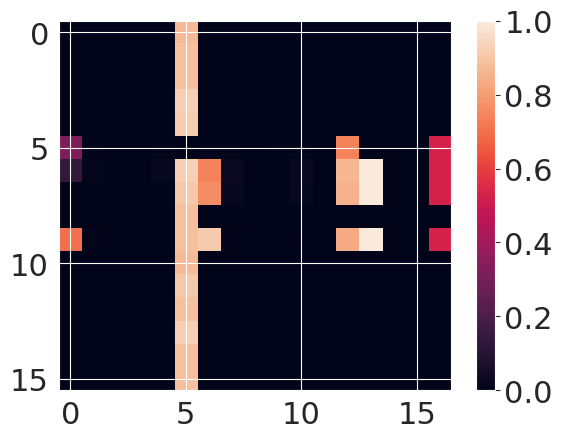

ORIGINAL LABEL: 3 COORDINATES [ -5.0828886 78.5254 ]


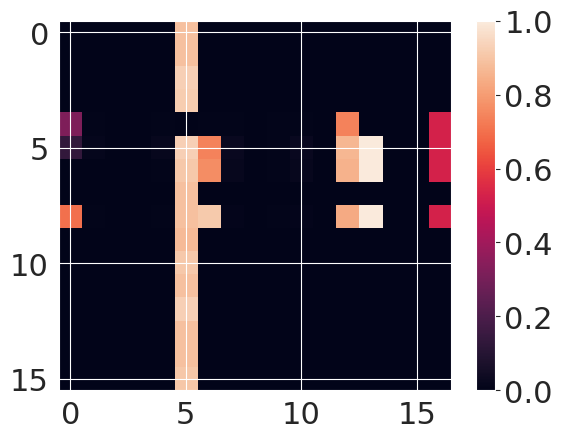

ORIGINAL LABEL: 3 COORDINATES [ -9.528352 114.204216 ]


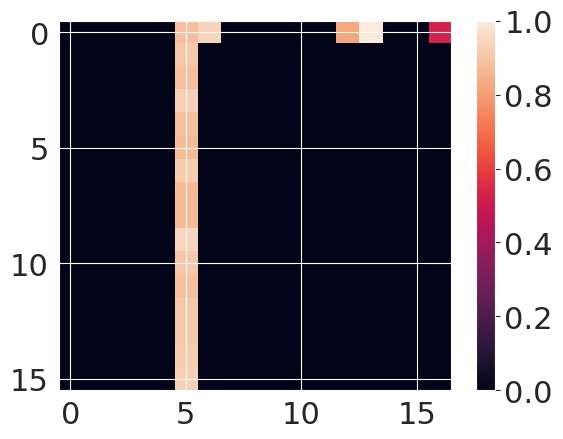

ORIGINAL LABEL: 3 COORDINATES [ -19.146624 94.825424 ]


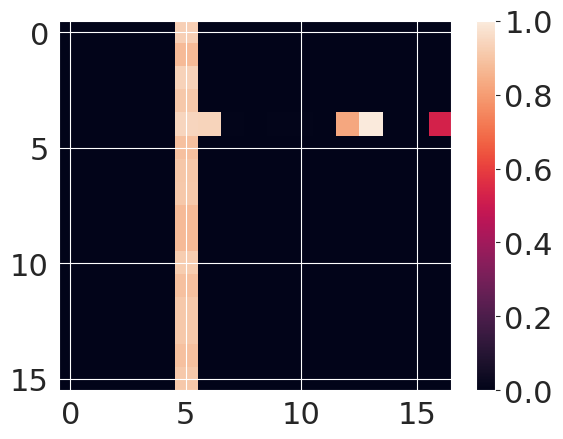

ORIGINAL LABEL: 3 COORDINATES [ -58.167423 90.9832 ]


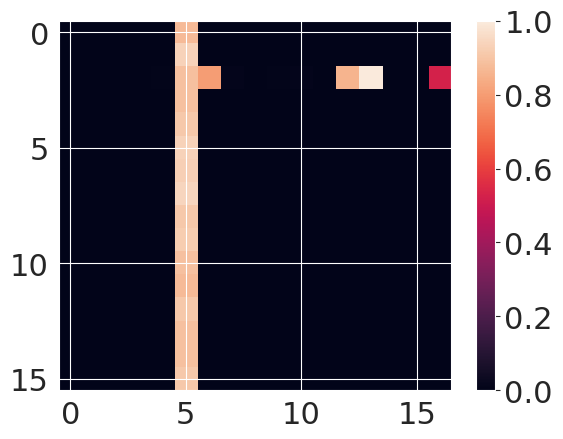

ORIGINAL LABEL: 3 COORDINATES [ -70.78119 39.29526 ]


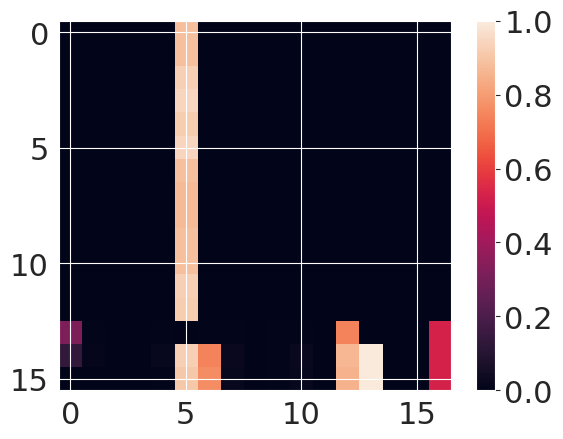

ORIGINAL LABEL: 3 COORDINATES [ -32.01027 97.90126 ]


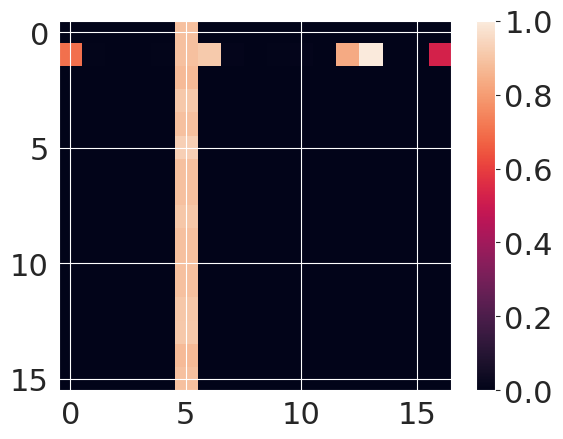

ORIGINAL LABEL: 3 COORDINATES [ -37.81507 104.73986 ]


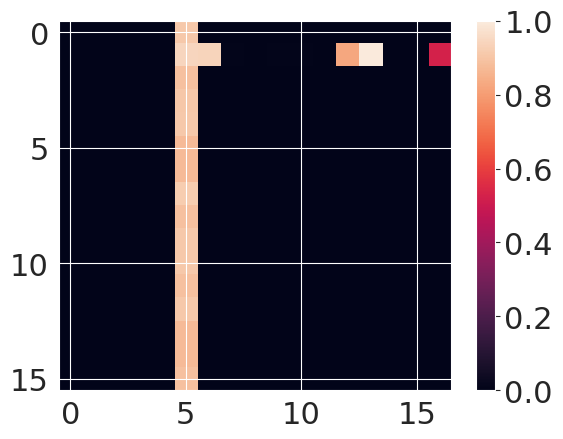

ORIGINAL LABEL: 3 COORDINATES [ -50.058445 49.370907 ]


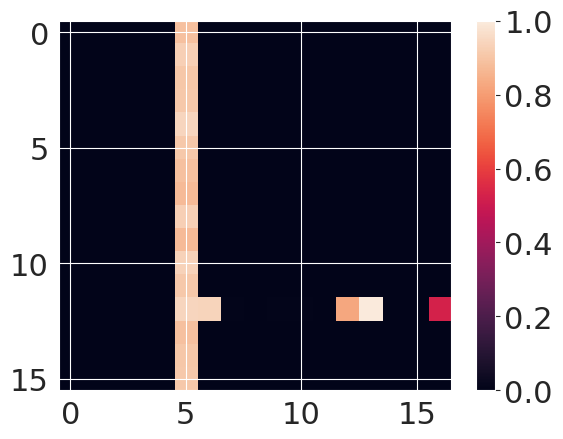

ORIGINAL LABEL: 3 COORDINATES [ -32.822838 51.474373 ]


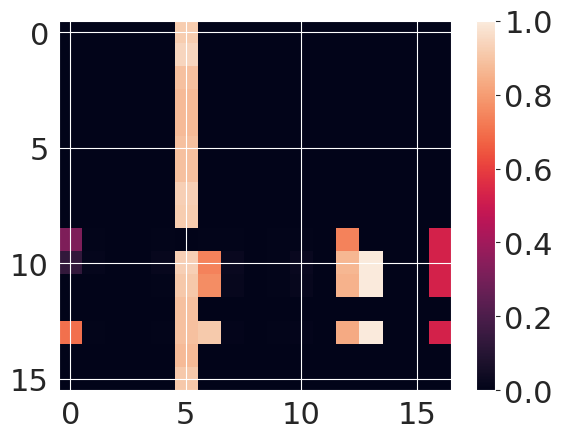

ORIGINAL LABEL: 3 COORDINATES [ -19.160683 94.82377 ]


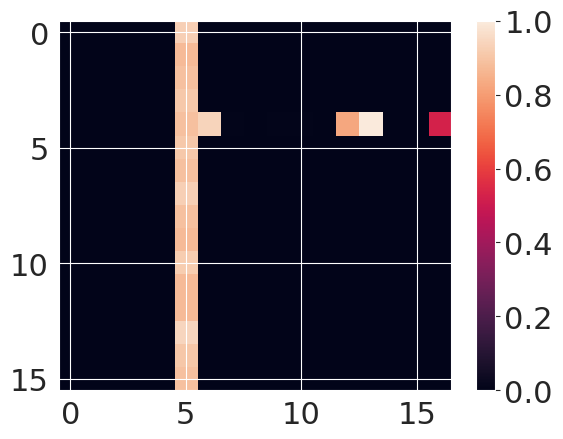

ORIGINAL LABEL: 3 COORDINATES [ -27.591093 69.80931 ]


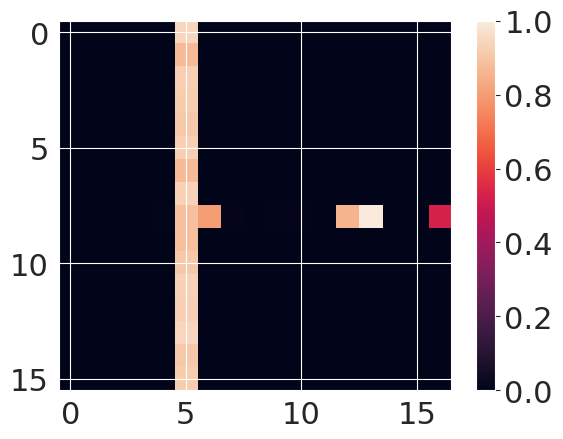

ORIGINAL LABEL: 3 COORDINATES [ -19.21547 94.6992 ]


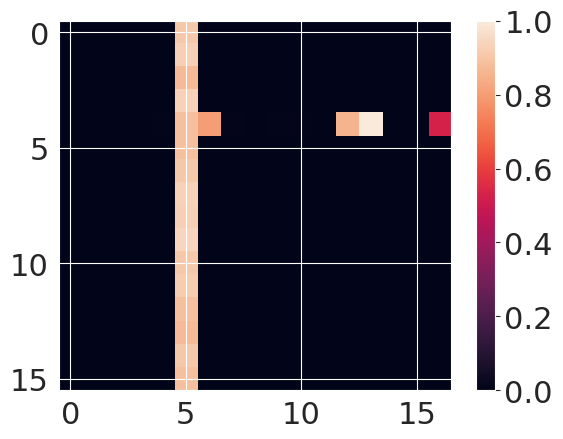

ORIGINAL LABEL: 3 COORDINATES [ 51.801617 83.27199 ]


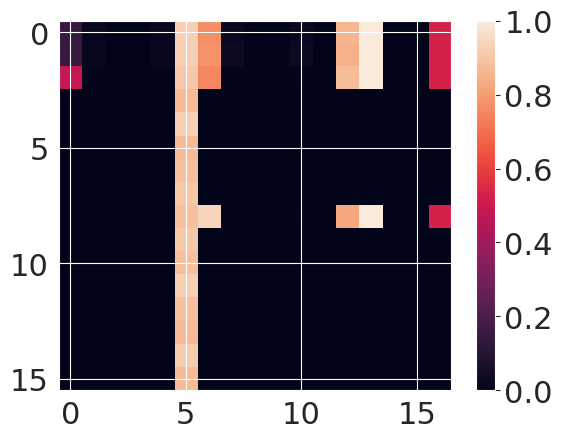

ORIGINAL LABEL: 3 COORDINATES [ -52.062424 61.009445 ]


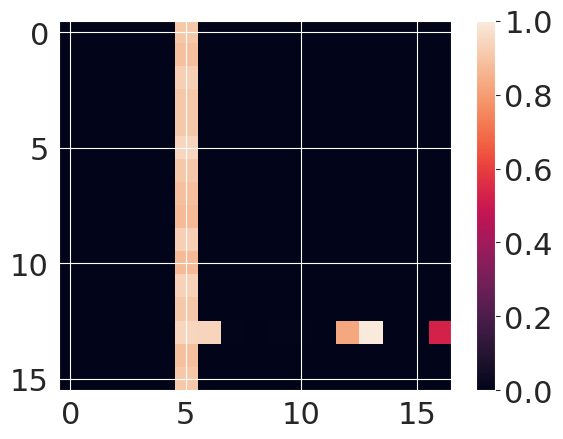

ORIGINAL LABEL: 3 COORDINATES [ -21.53965 52.236385 ]


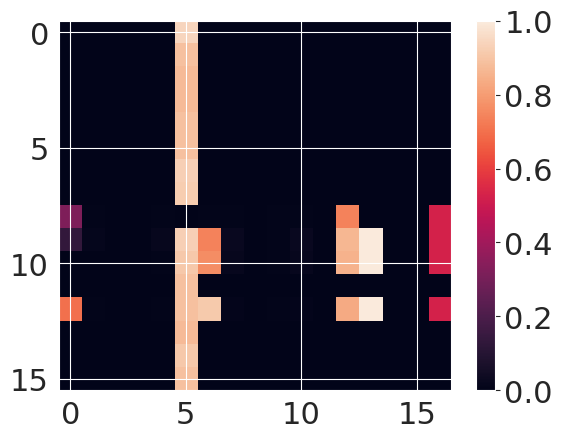

ORIGINAL LABEL: 3 COORDINATES [ -37.820675 104.73665 ]


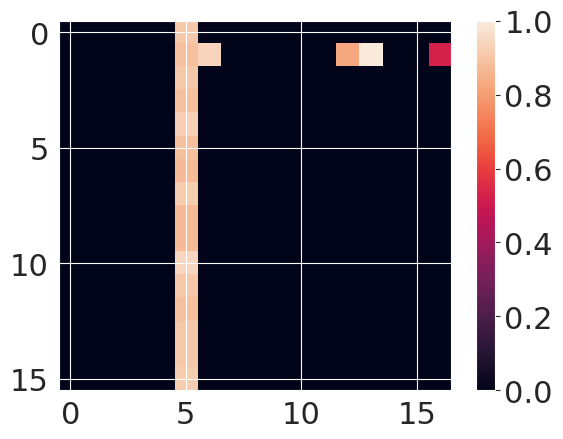

ORIGINAL LABEL: 3 COORDINATES [ -57.791912 68.19946 ]


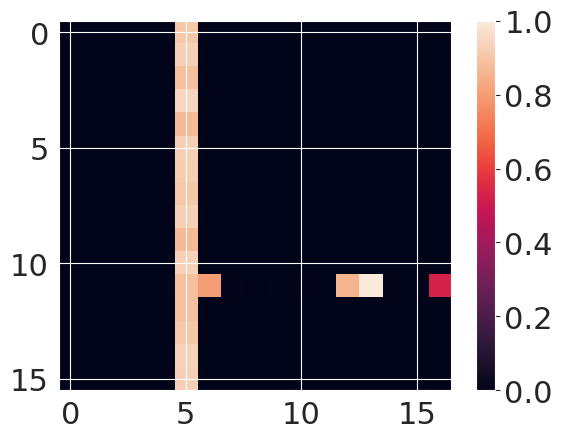

ORIGINAL LABEL: 3 COORDINATES [ -53.03236 100.90194 ]


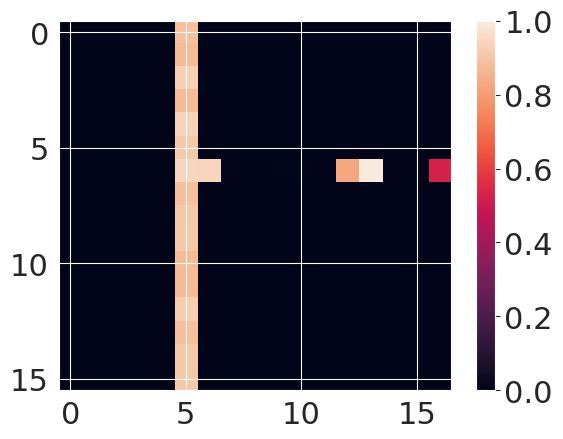

ORIGINAL LABEL: 3 COORDINATES [ -58.248386 91.09253 ]


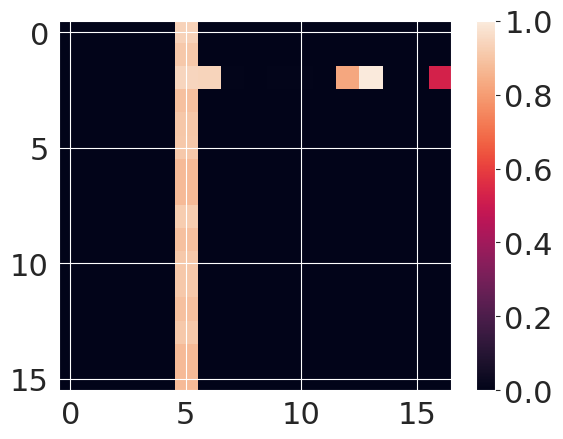

ORIGINAL LABEL: 3 COORDINATES [ -38.575386 40.70642 ]


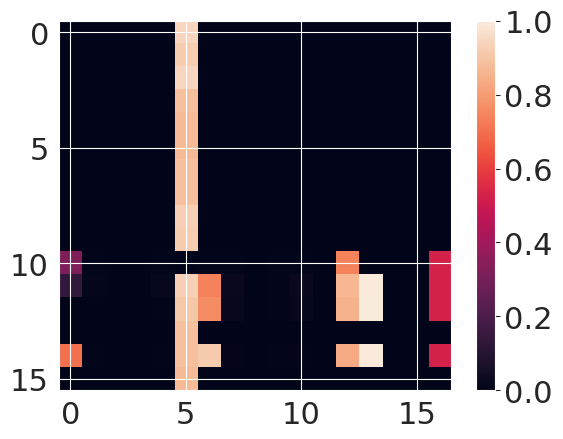

ORIGINAL LABEL: 3 COORDINATES [ -23.5064 110.32092 ]


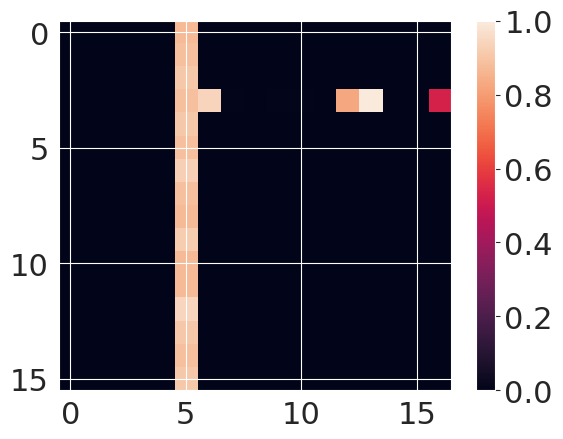

ORIGINAL LABEL: 3 COORDINATES [ -9.615401 114.104645 ]


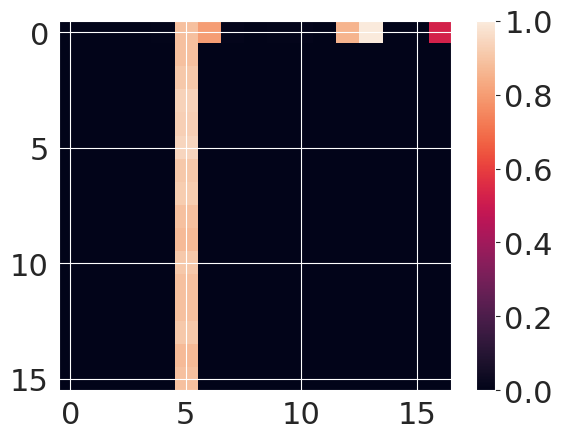

ORIGINAL LABEL: 3 COORDINATES [ 13.443883 93.87319 ]


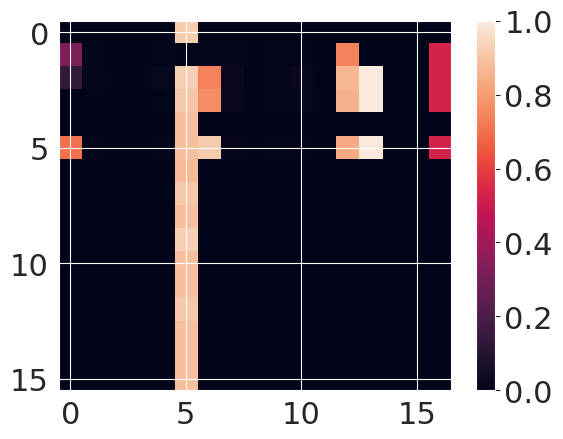

ORIGINAL LABEL: 3 COORDINATES [ -35.489864 86.40393 ]


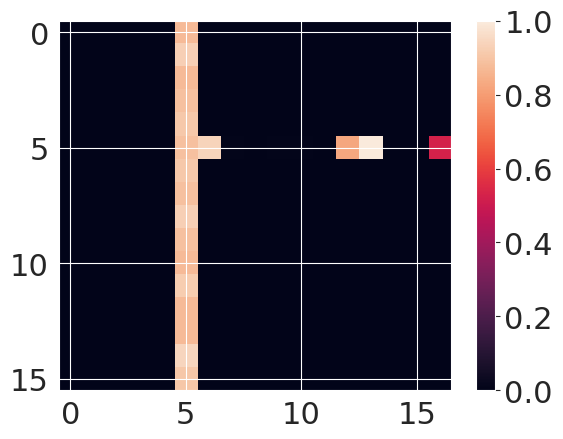

ORIGINAL LABEL: 3 COORDINATES [ -57.97271 68.4564 ]


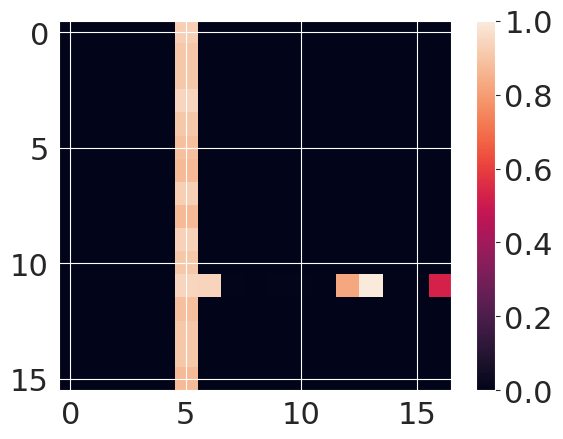

ORIGINAL LABEL: 3 COORDINATES [ 43.0649 92.99017 ]


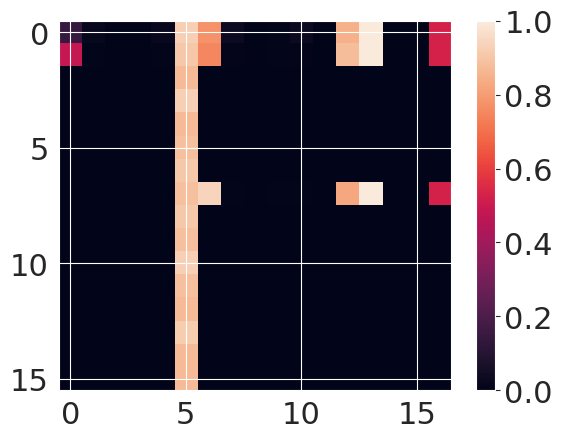

ORIGINAL LABEL: 3 COORDINATES [ 0.09051476 96.66753 ]


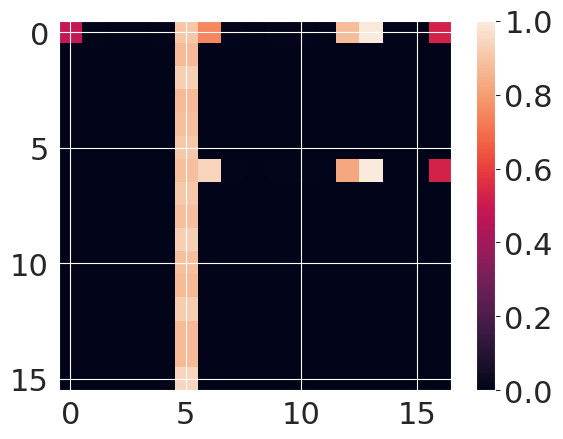

ORIGINAL LABEL: 3 COORDINATES [ -33.722366 62.252316 ]


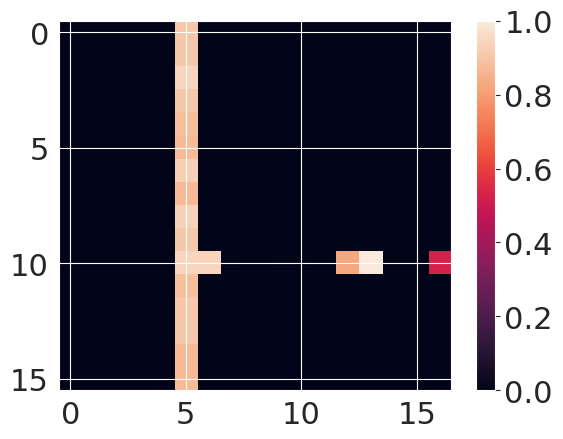

ORIGINAL LABEL: 3 COORDINATES [ -51.177574 38.241127 ]


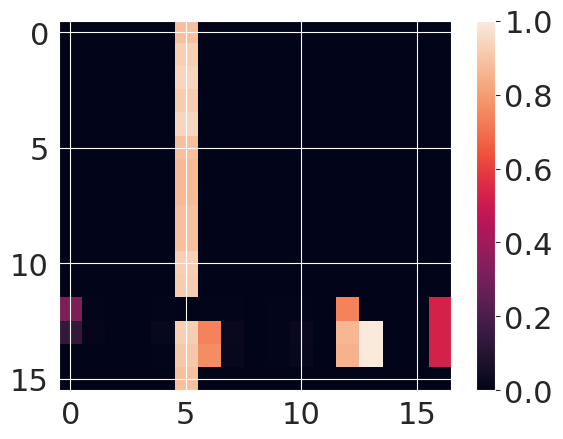

ORIGINAL LABEL: 3 COORDINATES [ 28.472977 84.31028 ]


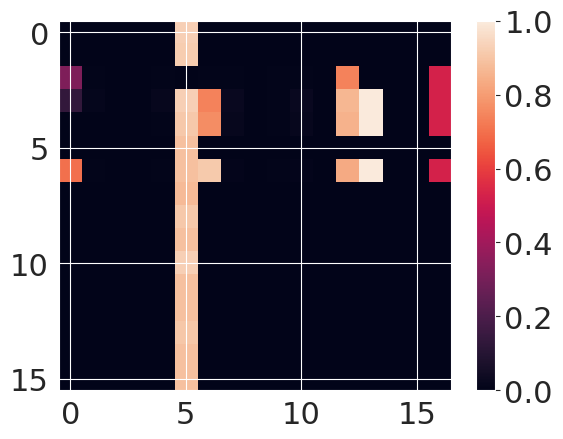

ORIGINAL LABEL: 3 COORDINATES [ 34.614216 91.34374 ]


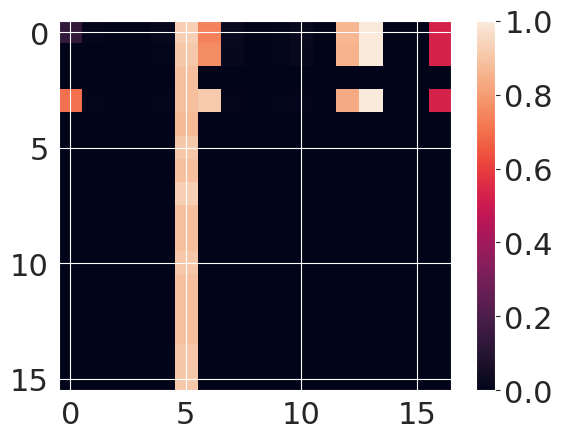

ORIGINAL LABEL: 3 COORDINATES [ 10.990264 75.07827 ]


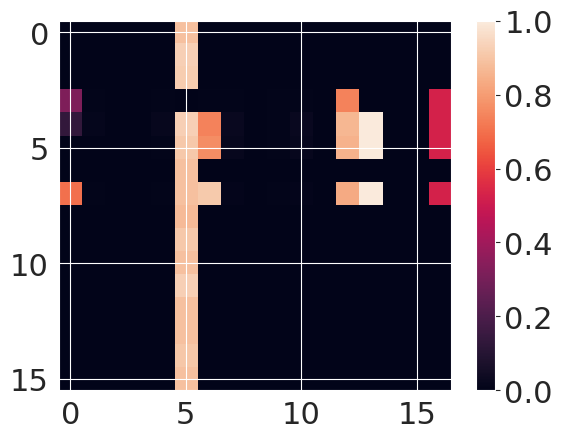

ORIGINAL LABEL: 3 COORDINATES [ -9.538131 114.19826 ]


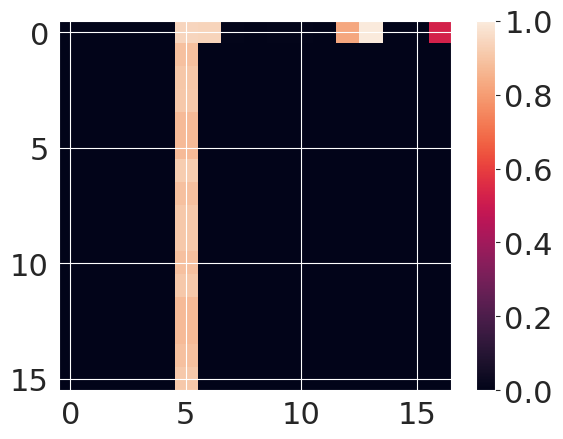

ORIGINAL LABEL: 3 COORDINATES [ -53.100044 100.60219 ]


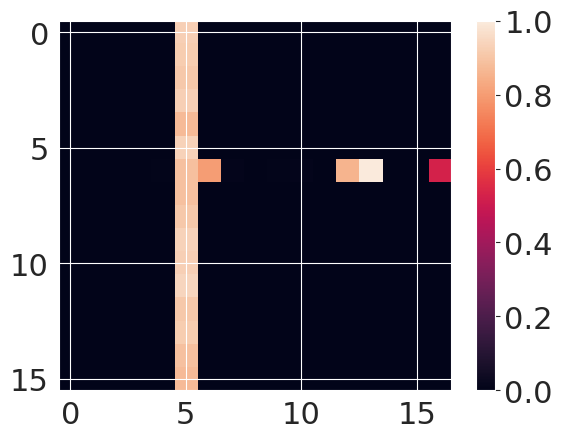

ORIGINAL LABEL: 3 COORDINATES [ 1.0460027 104.60015 ]


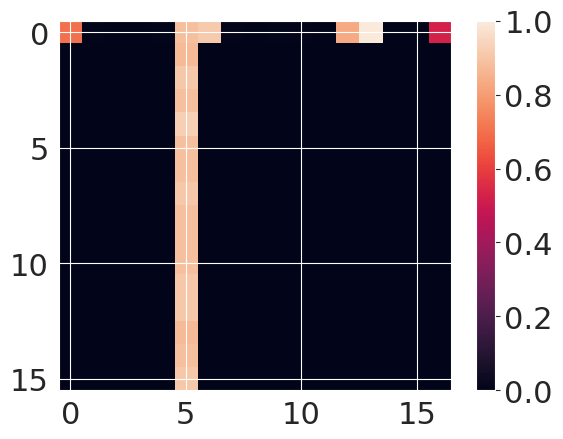

ORIGINAL LABEL: 3 COORDINATES [ -32.885708 26.300867 ]


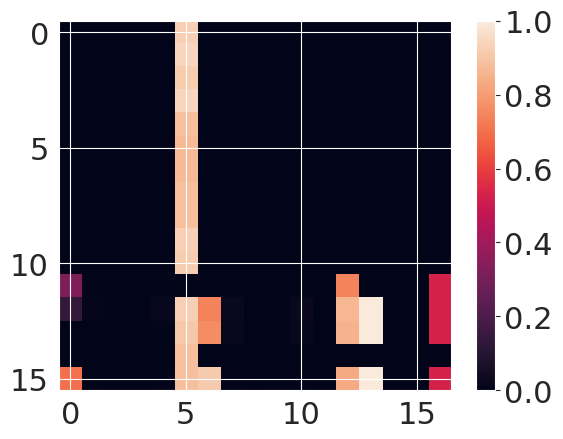

ORIGINAL LABEL: 3 COORDINATES [ -42.586967 73.63246 ]


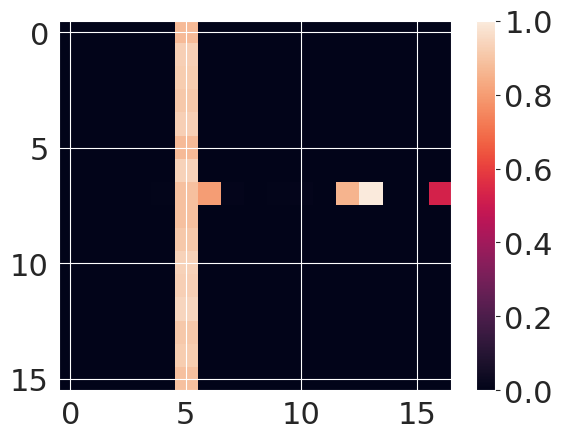

In [90]:
for c_ix in ctrl_before_relabel_ixs:
    if (tsne_results[c_ix,0] > -85) and ( tsne_results[c_ix,1] > 0):
        print("ORIGINAL LABEL:", df_classes_nr[c_ix], "COORDINATES [", tsne_results[c_ix,0], tsne_results[c_ix,1], "]")
        matplotlib.pyplot.imshow(df_subset_og_shape[c_ix])
        matplotlib.pyplot.colorbar()
        matplotlib.pyplot.show()